In [1]:
import numpy as np
np.random.seed(19906)
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing import image
import cv2
import os
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Activation
from keras.layers.core import Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.regularizers import l2

Using TensorFlow backend.


使用ResNet50模型

In [3]:
from keras.applications.resnet50 import ResNet50, preprocess_input

In [8]:
train_dir = "data/imgs/train2"
val_dir = "data/imgs/val2"
test_dir = "data/imgs/test1"
saved_weights = "saved_weights"
if not os.path.exists(saved_weights):
    os.mkdir(saved_weights)

分割验证集

In [ ]:
drivers_pd = pd.read_csv("data/drivers_img_nop081_list.csv")
imgs_pd = drivers_pd["img"]
class_pd = drivers_pd["classname"]
subject_pd = drivers_pd["subject"]
choices = ["p024", "p002"]

In [ ]:
split_valid.split(choice_ids=choices, 
                  train_pd_path="data/drivers_img_nop081_list.csv", 
                  train_aug_pd_path="data/drivers_img_aug_list.csv", 
                  train_dir=train_dir, 
                  val_dir=val_dir, 
                  test_dir=test_dir, 
                  origin_test_dir="data/imgs/test", 
                  saved_weights_dir="saved_weights")

In [2]:
def get_im_cv2(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

图片预处理

In [10]:
# 图像生成器输出的图像大小
out_image_size = (299, 299)
batch_size = 96

In [9]:
# 训练集图像生成器
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10.,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
    rescale=1./255
)

# 验证集图像生成器
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=out_image_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=out_image_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

构建模型

In [14]:
base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax', use_bias=False, kernel_regularizer=l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=predictions, name=base_model.name)

op = Adam(lr=0.00005, decay=2e-8)
model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])

开始训练

In [15]:
# 训练代数
epochs = 20

save_file = saved_weights + '/' + model.name + '_model.h5'
print("model name:", model.name, ", will save weight file:", save_file)
callbacks = [
    ModelCheckpoint(save_file, monitor="val_loss", mode="min", save_best_only=True, verbose=1, period=1),
    EarlyStopping(monitor="val_loss", verbose=1, mode="min", min_delta=0.0005, patience=2)
]

history = model.fit_generator(
    train_generator,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_generator)

Epoch 1/10
436/436 [==============================] - 1922s 4s/step - loss: 0.4078 - acc: 0.9286 - val_loss: 0.2400 - val_acc: 0.9693
Epoch 2/10
436/436 [==============================] - 1116s 3s/step - loss: 0.1486 - acc: 0.9960 - val_loss: 0.1841 - val_acc: 0.9721
Epoch 3/10
436/436 [==============================] - 1143s 3s/step - loss: 0.0920 - acc: 0.9973 - val_loss: 0.1520 - val_acc: 0.9664
Epoch 4/10
436/436 [==============================] - 1130s 3s/step - loss: 0.0571 - acc: 0.9979 - val_loss: 0.1179 - val_acc: 0.9714
Epoch 5/10
436/436 [==============================] - 1134s 3s/step - loss: 0.0365 - acc: 0.9984 - val_loss: 0.1626 - val_acc: 0.9492
Epoch 6/10
436/436 [==============================] - 1119s 3s/step - loss: 0.0304 - acc: 0.9981 - val_loss: 0.1991 - val_acc: 0.9364
Epoch 00006: early stopping


绘制图型

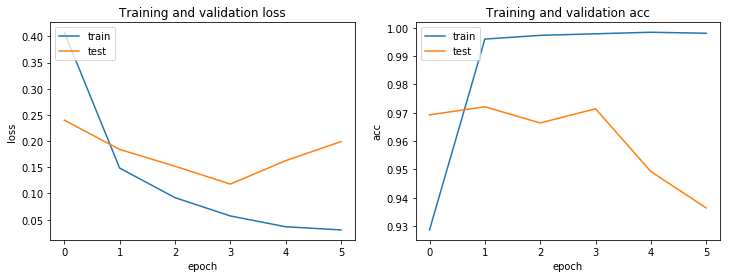

In [17]:
# 绘制图型
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Training and validation acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

测试预测结果

In [18]:
from keras.models import load_model

pred_model = load_model("saved_weights/resnet50_model.h5")

预测所有测试集，并生成提交kaggle的报告

In [19]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)
pred_batch_size=128

test_generator = test_datagen.flow_from_directory(test_dir, out_image_size, shuffle=False, 
                                             batch_size=pred_batch_size, class_mode=None)

test_generator.filenames[0]

Found 79726 images belonging to 1 classes.


'test/img_1.jpg'

In [20]:
sub_df = pd.read_csv("data/sample_submission.csv")

y_preds = pred_model.predict_generator(test_generator, verbose=1)
y_preds = y_preds.clip(min=0.005, max=0.995)
print("y_pred shape {}".format(y_preds.shape))

for i, fname in enumerate(test_generator.filenames):
    y_pred = y_preds[i]
    for k, c in enumerate(y_pred):
        sub_df.at[i, 'c'+str(k)] = c

print(sub_df.head())

sub_df.to_csv('data/pred.csv', index=None)
print("predict done.")

623/623 [==============================] - 1700s 3s/step
y_pred shape (79726, 10)
              img        c0     c1        c2        c3     c4     c5     c6  \
0       img_1.jpg  0.005000  0.005  0.005000  0.005000  0.005  0.995  0.005   
1      img_10.jpg  0.005000  0.005  0.005000  0.005000  0.005  0.995  0.005   
2     img_100.jpg  0.976096  0.005  0.005000  0.006738  0.005  0.005  0.005   
3    img_1000.jpg  0.005809  0.005  0.050625  0.005000  0.005  0.005  0.005   
4  img_100000.jpg  0.005000  0.005  0.005000  0.995000  0.005  0.005  0.005   

      c7        c8     c9  
0  0.005  0.005000  0.005  
1  0.005  0.005000  0.005  
2  0.005  0.005000  0.005  
3  0.005  0.918554  0.005  
4  0.005  0.005000  0.005  
predict done.


提交到kaggle中后得到成绩：private:  0.31309, public: 0.35854